In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.sparse import save_npz
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from joblib import load, dump
import joblib
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [3]:
train_df = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_train_tokenized.csv', encoding='utf-8-sig')
val_df   = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_val_tokenized.csv', encoding=' utf-8-sig')
test_df  = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_test_tokenized.csv', encoding='utf-8-sig')

In [4]:
print(f"  - train_tokenized.csv ({len(train_df)} samples)")
print(f"  - val_tokenized.csv ({len(val_df)} samples)")
print(f"  - test_tokenized.csv ({len(test_df)} samples)")

  - train_tokenized.csv (5140 samples)
  - val_tokenized.csv (661 samples)
  - test_tokenized.csv (1543 samples)


In [ ]:
# label_cols = ['economic', 'entertainment', 'life', 'politic', 'sport', 'technology']

X_train_text = train_df['content']
y_train = train_df['label']

X_val_text = val_df['content']
y_val = val_df['label']

X_test_text = test_df['content']
y_test = test_df['label']

In [7]:
count_vec = CountVectorizer(
    analyzer=str.split,
    max_features=None,
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2)
)

X_train_count = count_vec.fit_transform(train_df['content'])
X_val_count   = count_vec.transform(val_df['content'])
X_test_count  = count_vec.transform(test_df['content'])

print(f"Vocabulary size: {len(count_vec.vocabulary_):,}")
print(f"Bow matrix shape (train): {X_train_count.shape}")
print(f"Bow matrix shape (val): {X_val_count.shape}")
print(f"Bow matrix shape (test): {X_test_count.shape}")

C:\Users\Kimlang\AppData\Roaming\Python\Python314\site-packages\sklearn\feature_extraction\text.py:533: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Vocabulary size: 13,222
Bow matrix shape (train): (5140, 13222)
Bow matrix shape (val): (661, 13222)
Bow matrix shape (test): (1543, 13222)


In [ ]:
label_map = {
    0: "economic",
    1: "entertainment",
    2: "life",
    3: "politic",
    4: "sport",
    5: "technology"
}
name_to_id = {v: k for k, v in label_map.items()}

In [19]:
feature_names_count = np.array(count_vec.get_feature_names_out())
top_n = 10

print("=" * 80)
print("TOP 10 MOST FREQUENT WORDS (BoW) PER CATEGORY")
print("=" * 80)

for label_id, label_name in label_map.items():
    # ✅ Correct mask for INTEGER labels
    pos_mask = (y_train.values == label_id)
    pos_count = pos_mask.sum()

    if pos_count == 0:
        print(f"\n{label_name.upper():<12} : No samples")
        continue

    # Average word counts for this class
    avg_counts = np.asarray(
        X_train_count[pos_mask].mean(axis=0)
    ).ravel()

    # Top-N words
    top_idx = avg_counts.argsort()[-top_n:][::-1]

    print(f"\n{label_name.upper():<12} (label={label_id}, n={pos_count})")
    print("-" * 50)

    for i, idx in enumerate(top_idx):
        term = feature_names_count[idx]
        score = avg_counts[idx]
        print(f"{i+1}. {term:<20} {int(score)} time")

TOP 10 MOST FREQUENT WORDS (BoW) PER CATEGORY

ECONOMIC     (label=0, n=851)
--------------------------------------------------
1. កម្ពុជា              7 time
2. លោក                  5 time
3. ឆ្នាំ                5 time
4. ប្រទេស               5 time
5. ជា                   4 time
6. នឹង                  3 time
7. នៃ                   3 time
8. ពី                   3 time
9. ក្រុមហ៊ុន            3 time
10. ដោយ                  2 time

ENTERTAINMENT (label=1, n=700)
--------------------------------------------------
1. ជា                   3 time
2. ពី                   2 time
3. លោក                  2 time
4. ឆ្នាំ                2 time
5. មិន                  2 time
6. ដោយ                  1 time
7. ហើយ                  1 time
8. ក៏                   1 time
9. នាង                  1 time
10. មួយ                  1 time

LIFE         (label=2, n=698)
--------------------------------------------------
1. ជា                   3 time
2. ឆ្នាំ                3 time
3. ពី                  

## Train classifier with class imbalance handling

In [20]:
# =========================================================
# Build classifiers function
# =========================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

def build_classifiers(random_state: int = 42):
    """
    Build a dictionary of classifiers for BoW + PCA text classification.

    Returns:
        dict: Dictionary containing initialized classifiers
    """
    models = {}

    # Logistic Regression
    lr = LogisticRegression(
        penalty="l2",
        C=0.8,
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
        random_state=random_state
    )
    models["logistic"] = lr  # Single-label multi-class, no OneVsRest needed

    # Linear SVM
    svm = LinearSVC(
        C=0.1,
        loss="squared_hinge",
        class_weight="balanced",
        max_iter=3000,
        random_state=random_state
    )
    models["svm"] = svm

    # Random Forest
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=25,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=random_state
    )
    models["random_forest"] = rf

    # XGBoost
    xgb = XGBClassifier(
        n_estimators=600,
        learning_rate=0.07,
        max_depth=6,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multi:softmax",   # <-- use multi-class softmax
        num_class=6,                 # <-- number of classes
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=random_state
    )
    models["xgboost"] = xgb

    return models

In [ ]:
# =========================================================
# Train and evaluate classifiers without PCA
# =========================================================
from sklearn.metrics import f1_score, classification_report

label_cols = ['economic', 'entertainment', 'life', 'politic', 'sport', 'technology']
results = {}

print("\nTraining and evaluating models (BoW )\n")

classifiers = build_classifiers(random_state=42)

for model_name, model in classifiers.items():
    print(f"→ Training {model_name}...")

    # Fit model on  training data
    model.fit(X_train_count, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val_count)

    # Compute macro F1 score
    macro_f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)
    results[model_name] = macro_f1

    # Print classification report
    print(f"{model_name} — Validation Macro F1: {macro_f1:.4f}")
    print(classification_report(
        y_val,
        y_pred,
        target_names=label_cols,
        zero_division=0
    ))
    print("-" * 60)

# =========================================================
# Summary of results
# =========================================================
print("\nValidation Macro F1 scores for all models:")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")


Training and evaluating models (BoW )

→ Training logistic...


C:\Users\Kimlang\AppData\Roaming\Python\Python314\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


logistic — Validation Macro F1: 0.9211
               precision    recall  f1-score   support

     economic       0.93      0.91      0.92       109
entertainment       0.95      0.96      0.95        90
         life       0.84      0.81      0.82        90
      politic       0.94      0.98      0.96       192
        sport       0.99      0.98      0.98        90
   technology       0.91      0.88      0.89        90

     accuracy                           0.93       661
    macro avg       0.92      0.92      0.92       661
 weighted avg       0.93      0.93      0.93       661

------------------------------------------------------------
→ Training svm...
svm — Validation Macro F1: 0.9095
               precision    recall  f1-score   support

     economic       0.93      0.91      0.92       109
entertainment       0.92      0.93      0.93        90
         life       0.81      0.78      0.80        90
      politic       0.94      0.98      0.96       192
        sport      

Plotting confusion matrices using: logistic


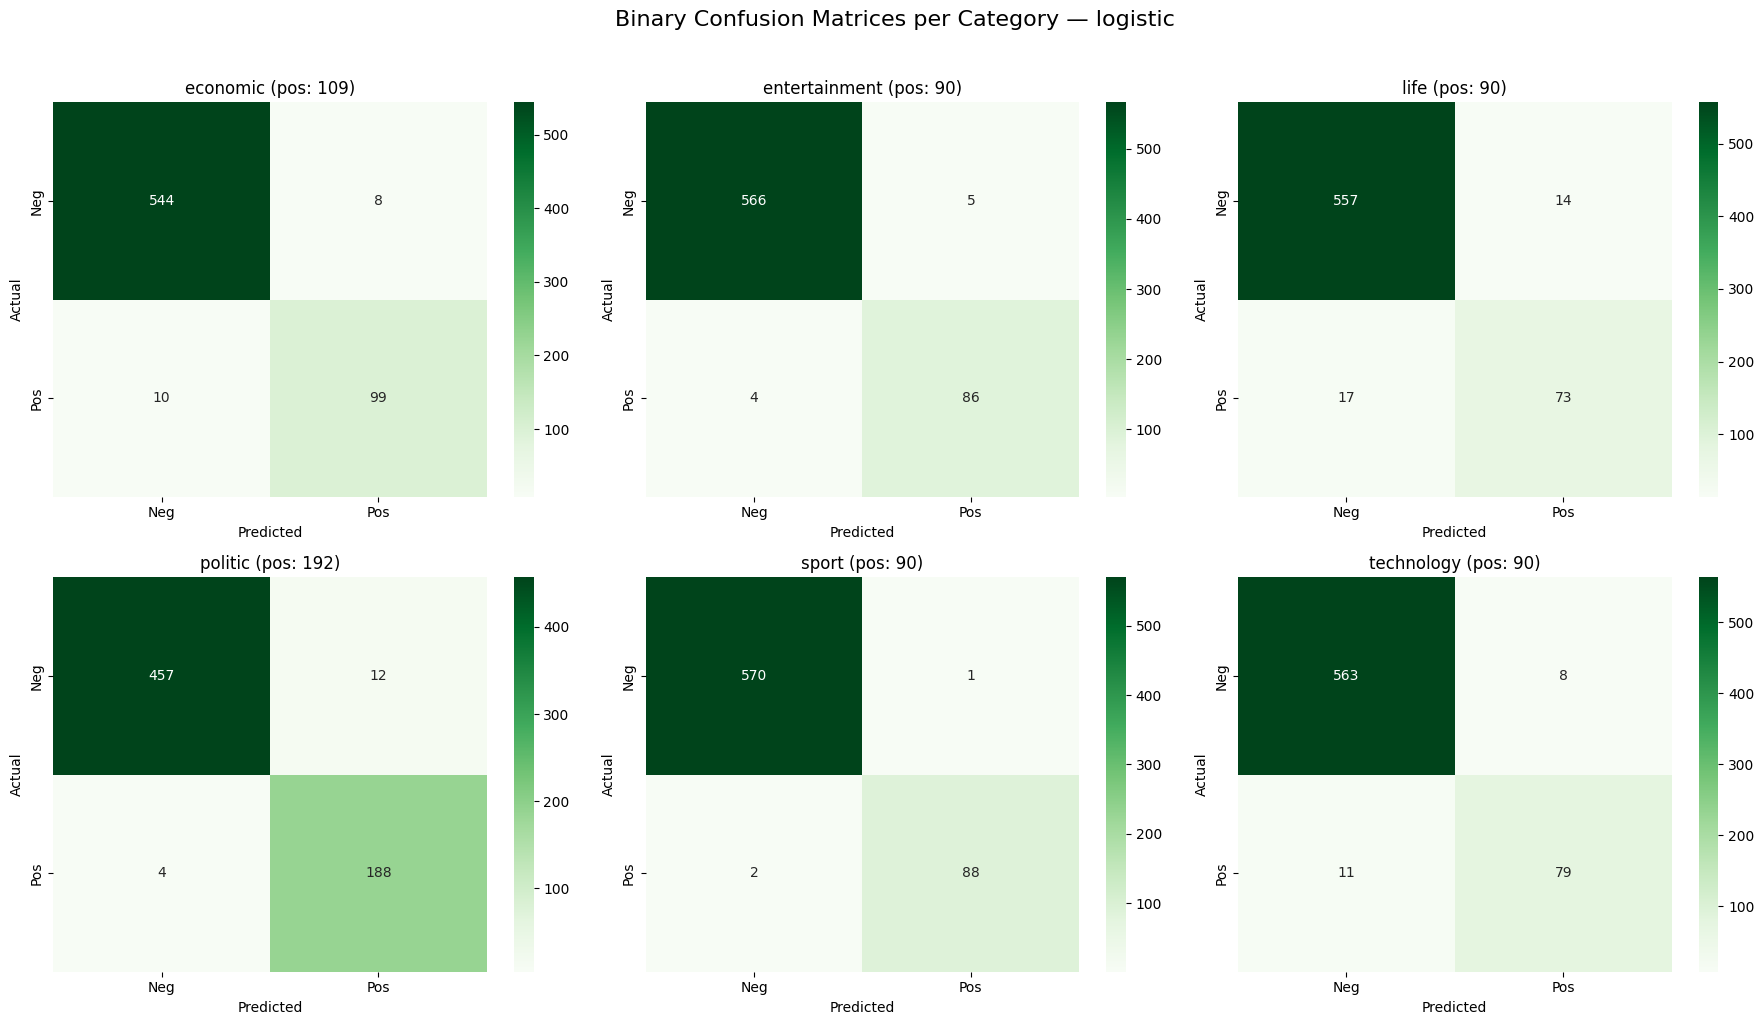

In [28]:
best_model_name = max(results, key=results.get)
best_clf = classifiers[best_model_name]

# Predict using original features (NOT PCA)
y_pred_best = best_clf.predict(X_val_count)

print(f"Plotting confusion matrices using: {best_model_name}")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    # Convert to binary: 1 if this class, 0 otherwise
    y_true_bin = (y_val == i).astype(int)
    y_pred_bin = (y_pred_best == i).astype(int)

    cm = confusion_matrix(y_true_bin, y_pred_bin)

    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Greens', ax=axes[i],
        xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos']
    )
    axes[i].set_title(f"{label} (pos: {y_true_bin.sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(f"Binary Confusion Matrices per Category — {best_model_name}", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [29]:
print("\n" + "="*80)
print(f"STEP 1: TEST SET EVALUATION - {best_model_name}")
print("="*80)

# Predict on TEST set (NO PCA)
y_pred_test = best_clf.predict(X_test_count)

test_macro_f1 = f1_score(
    y_test,
    y_pred_test,
    average='macro',
    zero_division=0
)

print(f"\nTest Macro F1: {test_macro_f1:.4f}")
print("\n" + classification_report(
    y_test,
    y_pred_test,
    target_names=label_cols,
    zero_division=0
))


STEP 1: TEST SET EVALUATION - logistic

Test Macro F1: 0.9010

               precision    recall  f1-score   support

     economic       0.86      0.89      0.87       256
entertainment       0.93      0.95      0.94       210
         life       0.79      0.73      0.76       210
      politic       0.96      0.96      0.96       449
        sport       0.98      0.98      0.98       209
   technology       0.89      0.89      0.89       209

     accuracy                           0.91      1543
    macro avg       0.90      0.90      0.90      1543
 weighted avg       0.91      0.91      0.91      1543




Test Set Confusion Matrices per Category


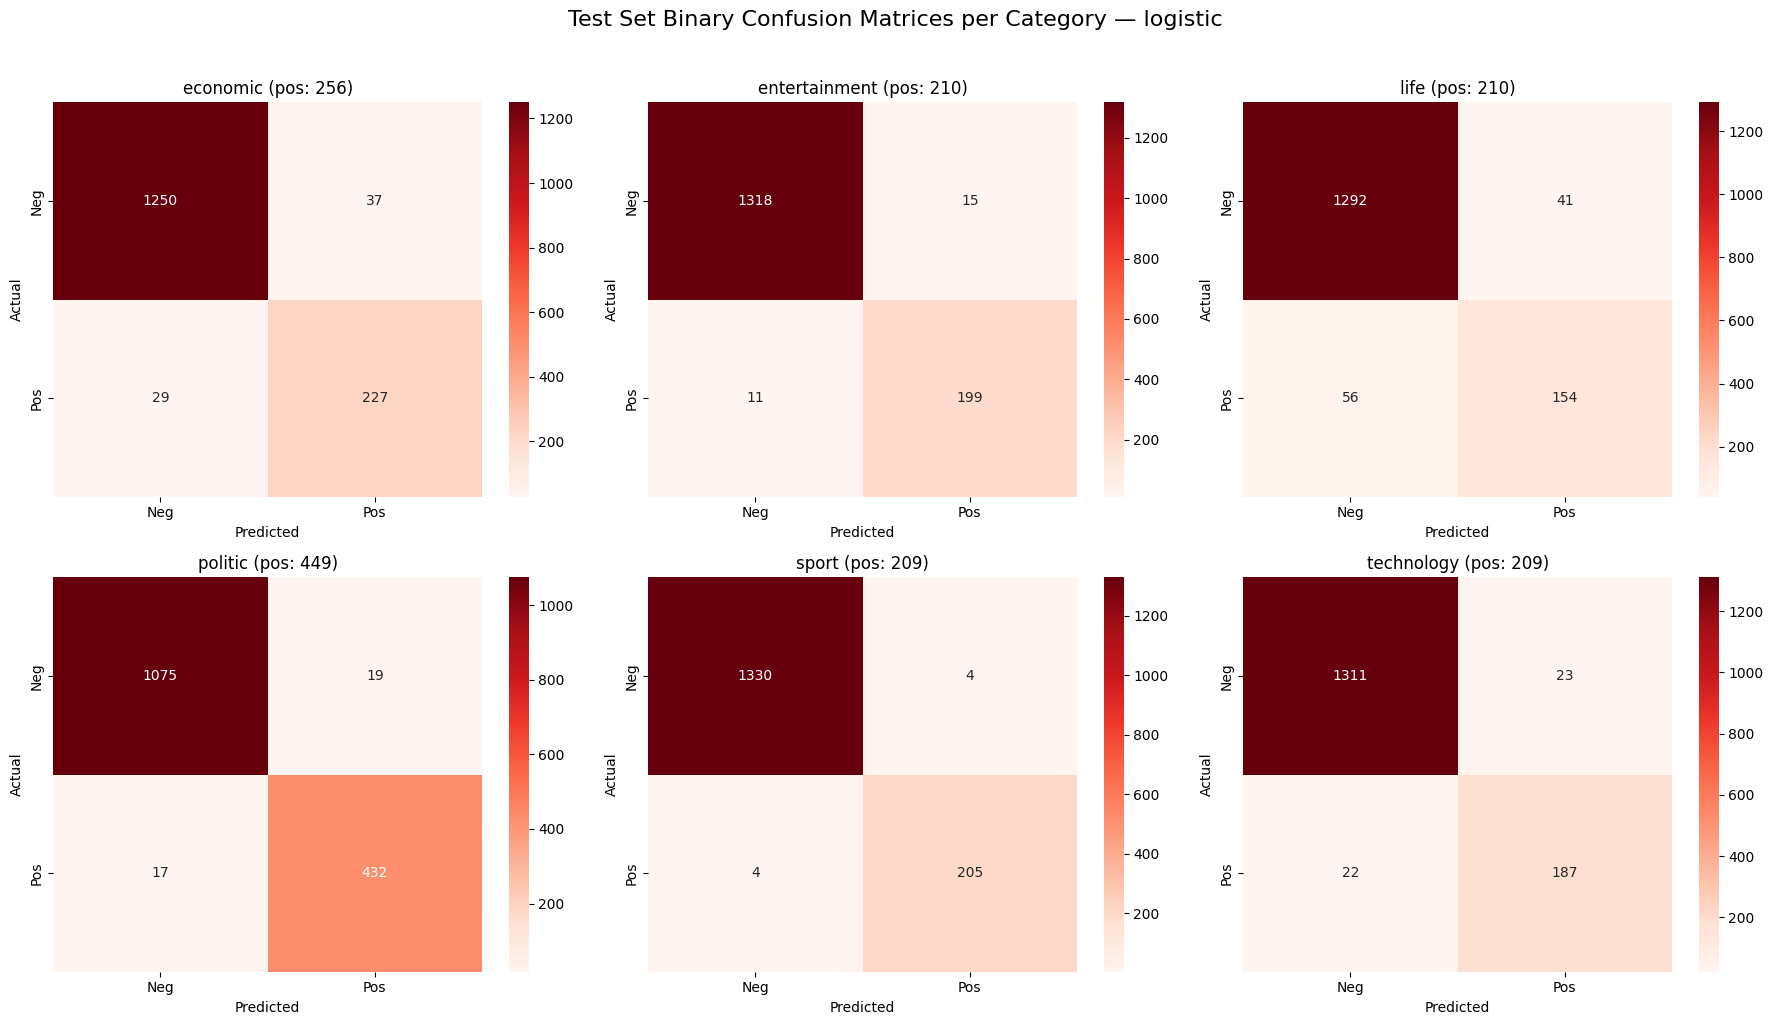

In [36]:
print("\n" + "="*80)
print("Test Set Confusion Matrices per Category")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    # Binary: 1 if current class, else 0
    y_true_bin = (y_test == i).astype(int)
    y_pred_bin = (y_pred_test == i).astype(int)
    
    cm = confusion_matrix(y_true_bin, y_pred_bin)
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Reds',
        ax=axes[i],
        xticklabels=['Neg', 'Pos'],
        yticklabels=['Neg', 'Pos']
    )
    
    axes[i].set_title(f"{label} (pos: {y_true_bin.sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(f"Test Set Binary Confusion Matrices per Category — {best_model_name}", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Saving model

In [41]:
import os
from joblib import dump

save_dir = '../BOW_PROJECT/models/bow_models_without_pca'
os.makedirs(save_dir, exist_ok=True)

dump(classifiers["logistic"], f'{save_dir}/logistic_regression_model.joblib')
dump(classifiers["svm"], f'{save_dir}/linear_svm_model.joblib')
dump(classifiers["random_forest"], f'{save_dir}/random_forest_model.joblib')
dump(classifiers["xgboost"], f'{save_dir}/xgboost_model.joblib')

# Also save the CountVectorizer
dump(count_vec, f'{save_dir}/count_vectorizer.joblib')

# Save class labels for inference
import pandas as pd
pd.DataFrame(label_cols, columns=["label"]).to_csv(f'{save_dir}/classes.csv', index=False)

print("✅ Models and preprocessors saved successfully!")

✅ Models and preprocessors saved successfully!


## Testing a single sentence

In [43]:
import re
import numpy as np
import pandas as pd
from joblib import load
from khmernltk import word_tokenize  # make sure khmer-nltk is installed

# -----------------------------
# 1. Load saved objects
# -----------------------------
count_vec = load('../BOW_PROJECT/models/bow_models_without_pca/count_vectorizer.joblib')
model     = load('../BOW_PROJECT/models/bow_models_without_pca/logistic_regression_model.joblib')
classes   = pd.read_csv('../BOW_PROJECT/models/bow_models_without_pca/classes.csv')['label'].tolist()

# -----------------------------
# 2. Preprocessing functions
# -----------------------------
def clean_khmer_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<[^>]+>', '', text)                    # remove HTML
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)      # zero-width chars
    text = re.sub(r'[!"#$%&\'()*+,—./:;<=>?@[\]^_`{|}~។៕៖ៗ៘៙៚៛«»-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def khmer_tokenize(text: str) -> str:
    """
    Clean and tokenize Khmer text using khmer-nltk.
    Output is a SPACE-separated token string
    (required for CountVectorizer(analyzer=str.split))
    """
    cleaned = clean_khmer_text(text)
    if not cleaned:
        return ""

    tokens = word_tokenize(cleaned, return_tokens=True)
    tokens = [tok for tok in tokens if tok.strip()]
    return " ".join(tokens)

# -----------------------------
# 3. Prediction function
# -----------------------------
def predict_khmer_text(text: str):
    # Preprocess
    tokenized_text = khmer_tokenize(text)
    if not tokenized_text:
        return "No valid text to predict"

    # BoW transform
    bow_vec = count_vec.transform([tokenized_text])

    # Predict (multi-class)
    pred = model.predict(bow_vec)   # shape: (1,)
    class_index = int(pred[0])
    return classes[class_index]

# -----------------------------
# 4. Test
# -----------------------------
new_text = """
រដ្ឋាភិបាលជប៉ុន សូមស្វាគមន៍លទ្ធផលកិច្ចប្រជុំគណៈកម្មាធិការព្រំដែនទូទៅ
រវាងកម្ពុជា និងថៃ ដែលបានធ្វើឡើងនៅម៉ាឡេស៊ី នៅថ្ងៃទី២៣ ខែតុលា។
នេះបើតាមសេចក្តីថ្លែងការណ៍របស់លោក Kitamura Toshihiro
អ្នកនាំពាក្យក្រសួងការបរទេសជប៉ុន។
"""

predicted_category = predict_khmer_text(new_text)
print("Predicted category:", predicted_category)

| 2026-01-14 00:50:25,180 | INFO | khmer-nltk | Loaded model from C:\Users\Kimlang\AppData\Roaming\Python\Python314\site-packages\khmernltk\word_tokenize\sklearn_crf_ner_10000.sav |


Predicted category: politic


In [44]:
print(khmer_tokenize(new_text))

រដ្ឋាភិបាល ជប៉ុន សូមស្វាគមន៍ លទ្ធផល កិច្ចប្រជុំ គណៈកម្មាធិការ ព្រំដែន ទូទៅ រវាង កម្ពុជា និង ថៃ ដែល បាន ធ្វើឡើង នៅ ម៉ាឡេស៊ី នៅ ថ្ងៃទី ២៣ ខែតុលា នេះ បើ តាម សេចក្តីថ្លែងការណ៍ របស់ លោក Kitamura Toshihiro អ្នកនាំពាក្យ ក្រសួង ការបរទេស ជប៉ុន
